## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


## 2. Знакомство с данными, базовый анализ и расширение данных

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Файл с исходными данными:

In [57]:
taxi_data = pd.read_csv('data/train.csv')
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Мы имеем данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### 2.1. Базовый анализ

Посмотрим на временные рамки, в которых мы работаем с данными. 

In [58]:
# переводим признак с датами в формат datatime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
# временные границы предоставленных данных
print(taxi_data['pickup_datetime'].max(), '-', taxi_data['pickup_datetime'].min())

2016-06-30 23:59:39 - 2016-01-01 00:00:17


In [59]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [60]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [61]:
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


### 2.2. Добавление данных

In [62]:
def add_datetime_features(df):
    """Функция принимает на вход таблицу с данными о поездках и возвращает ту же таблицу с добавленными в нее 3 столбцами:
    
    pickup_date - дата включения счетчика - начала поездки (без времени);
    pickup_hour - час дня включения счетчика;
    pickup_day_of_week - наименование дня недели, в который был включен счетчик.

    Args:
        df (Series): признак pickup_date

    Returns:
        DataFrame: датасет с тремя новыми признаками
    """
    
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

In [63]:
add_datetime_features(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


In [64]:
# таблица с данными о праздничных днях
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data.head()

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day


In [65]:
def add_holiday_features(df_taxi, df_holidays):
    """Функцию принимает на вход две таблицы: 
    - таблицу с данными о поездках;
    - таблицу с данными о праздничных днях
    и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, 
    начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

    Args:
        df_taxi (DataFrame): таблица с данными о поездках
        df_holidays (DataFrame): таблица с данными о праздничных днях

    Returns:
        DataFrame: измененная таблица с данными о поездках
    """
    
    df_holidays['date'] = pd.to_datetime(df_holidays['date'])
    df_taxi['pickup_date'] = pd.to_datetime(df_taxi['pickup_date'])
    df_taxi = df_taxi.merge(df_holidays['holiday'], how='left', left_on=df_taxi['pickup_date'], right_on=df_holidays['date'])
    df_taxi.drop(['key_0'], axis=1, inplace=True)
    df_taxi['holiday'] = df_taxi['holiday'].apply(lambda x: 0 if x is np.nan else 1)
    #df_taxi.drop('holiday', axis=1, inplace=True)
    return df_taxi

taxi_data = add_holiday_features(taxi_data, holiday_data)

In [66]:
taxi_data['holiday'].value_counts()

0    1407522
1      51122
Name: holiday, dtype: int64

In [67]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
osrm_data = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

In [68]:
osrm_data

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5
...,...,...,...,...
1458638,id2976426,28051.1,1462.5,13
1458639,id1440046,29616.3,1643.2,16
1458640,id1607338,25615.0,1765.1,30
1458641,id2071901,20284.1,1074.3,14


In [69]:
def add_osrm_features(df, osrm_data):
    """Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
    - таблицу с данными о поездках;
    - таблицу с данными из OSRM;
    и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
    - total_distance;
    - total_travel_time;
    - number_of_steps.

    Args:
        df (DataFrame): таблица с данными о поездках
        osrm_data (DataFrame): таблица с данными из OSRM

    Returns:
        DataFrame: измененная таблица с данными о поездках и данными из OSMR
    """
    
    df = df.merge(osrm_data, how='left', on="id")
    return df

In [70]:
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [71]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

In [72]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [73]:
def add_geographical_features(df):
    """Функцию принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
    - haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
    - direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

    Args:
        df (DataFrame): таблица с данными о поездках

    Returns:
        DataFrame: измененная таблица с данными о поездках и добавленными столбцами расстояния и направления
    """
    
    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'],
                                                      df['pickup_longitude'],
                                                      df['dropoff_latitude'],
                                                      df['dropoff_longitude'])
    df['direction'] = get_angle_direction(df['pickup_latitude'],
                                          df['pickup_longitude'],
                                          df['dropoff_latitude'],
                                          df['dropoff_longitude'])
    return df

In [74]:
taxi_data = add_geographical_features(taxi_data)

In [75]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(df, kmeans):
    """Функция принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. 
    Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.


    Args:
        df (DataFrame)
        kmeans

    Returns:
        DataFrame: измененная таблица с данными о поездках и добавленными столбцом географических кластеров
    """
    
    coords_df = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                df[['dropoff_latitude', 'dropoff_longitude']]))
    
    df['geo_cluster'] = kmeans.predict(coords_df)
    return df

taxi_data = add_cluster_features(taxi_data, kmeans)

/home/belov_engineer/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [76]:
weather_data = pd.read_csv('data/weather_data.csv')

def add_weather_features(df, weather_df):
    """Функцию add_weather_features() принимает на вход две таблицы:
    - таблицу с данными о поездках;
    - таблицу с данными о погодных условиях на каждый час;
    
    и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
    - temperature - температура;
    - visibility - видимость;
    - wind speed - средняя скорость ветра;
    - precip - количество осадков;
    - events - погодные явления.

    Args:
        df (DataFrame): таблица с данными о поездках
        weather_df (DataFrame): таблица с данными о погодных условиях на каждый час

    Returns:
        DataFrame: измененная таблица с данными о поездках и новыми данными о погоде
    """
    
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df['date'] = pd.to_datetime(weather_df['time'].dt.date)
    weather_df['hour'] = weather_df['time'].dt.hour
    
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])
    
    weather_df = weather_df[['date','hour','temperature','visibility','wind speed','precip','events']]
    
    df = pd.merge(df, weather_df,left_on=['pickup_date','pickup_hour'],right_on=['date','hour'],how='left') 
    df = df.drop(['date','hour'], axis=1)
    return df

taxi_data = add_weather_features(taxi_data, weather_data)

In [77]:
print('Количество поездок в снежную погоду:', taxi_data[taxi_data['events'] == 'Snow'].shape[0])
print('Доля пропусков в данных с погодными условиями:', (taxi_data['temperature'].isna().sum() / taxi_data.shape[0]) * 100)

Количество поездок в снежную погоду: 13126
Доля пропусков в данных с погодными условиями: 0.8248757064780714


In [78]:
def fill_null_weather_data(df):
    """Функция принимает на вход которая принимает на вход таблицу с данными о поездках и заполняет пропущенные значения в столбцах.

    Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip - медианным значением температуры, 
    влажности, скорости ветра и видимости в зависимости от даты начала поездки. 
    Пропуски в столбце events строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 
    Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps - медианным значением по столбцам. 

    Args:
        df (DataFrame): таблица с данными о поездках

    Returns:
        DataFrame: измененная таблица с данными о поездках и данными о погоде c пропущенными пропусками
    """
    
    weather = ['temperature', 'visibility', 'wind speed', 'precip']
    for i in weather:
        df[i] = df[i].fillna(value=df.groupby('pickup_date')[i].transform('median'))
    df['events'].fillna('None', inplace=True)
    distance = ['total_distance', 'total_travel_time', 'number_of_steps']
    for i in distance:
        df[i].fillna(value=df[i].median(),inplace=True)
    return df

taxi_data = fill_null_weather_data(taxi_data)

Найдем очевидные выбросы в целевой переменной - длительности поездки. 
Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Воспользуемся информацией о кратчайшем расстоянии, которое проезжает такси. Вычислим среднюю скорость автомобиля на кратчайшем пути.
Построим диаграмму рассеяния средней скорости движения автомобилей:


Text(0, 0.5, 'Average speed')

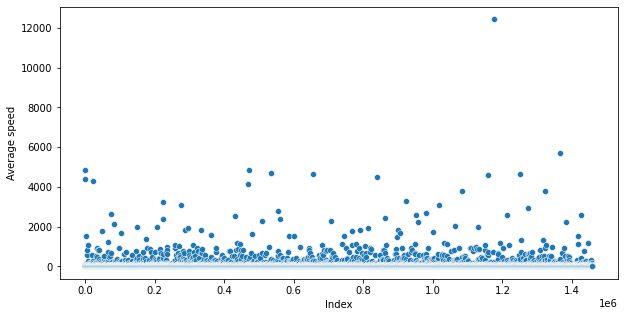

In [79]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


In [80]:
duration_drop = taxi_data[taxi_data['trip_duration'] > (24*60*60)].index # поездки, превышающие 24 часа
print('Выбросы по времени:', len(duration_drop))

taxi_data['avg_speed'] = avg_speed
speed_drop = taxi_data[taxi_data['avg_speed'] > 300].index # скорость выше 300 км/ч
print('Выбросы по средней скорости:', len(speed_drop))

taxi_data = taxi_data.drop(index=duration_drop, axis=0)
taxi_data = taxi_data.drop(index=speed_drop, axis=0)
taxi_data = taxi_data.drop('avg_speed', axis=1)

taxi_data

Выбросы по времени: 4
Выбросы по средней скорости: 407


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,311.7,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,589.6,11.0,6.049836,25.342196,9,7.2,2.8,18.5,8.1,Rain
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,642.9,10.0,7.824606,-150.788492,4,18.3,16.1,0.0,0.0,None
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,161.6,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None


## 3. Разведывательный анализ данных (EDA)

В этой части проекта:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним анализ визуализациями, иллюстрирующими исследование.


Начинаем с целевого признака.  Прологорифмируем признак длительности поездки, так как основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе.

In [81]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Text(0.5, 1.0, 'Распределение целевого признака trip_duration_log')

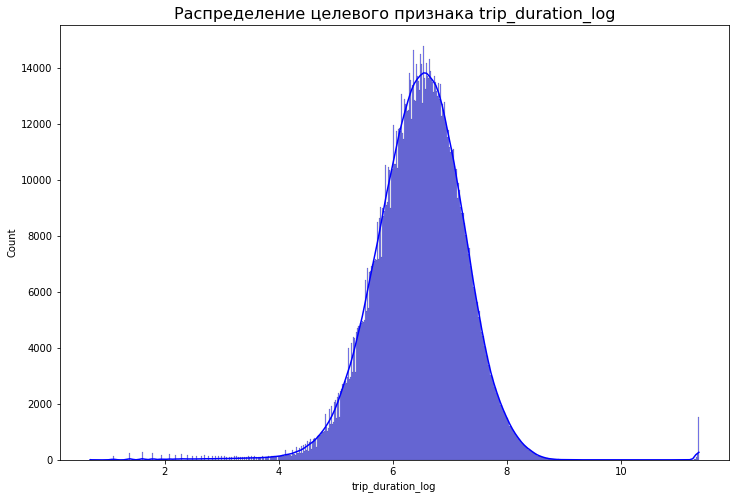

In [82]:
plt.figure(figsize=(12, 8))
hist_trip_dur = sns.histplot(data=taxi_data, x='trip_duration_log', kde=True, color='blue')
hist_trip_dur.axes.set_title('Распределение целевого признака trip_duration_log', fontsize=16)

Text(0.5, 1.0, 'Распределение целевого признака trip_duration_log')

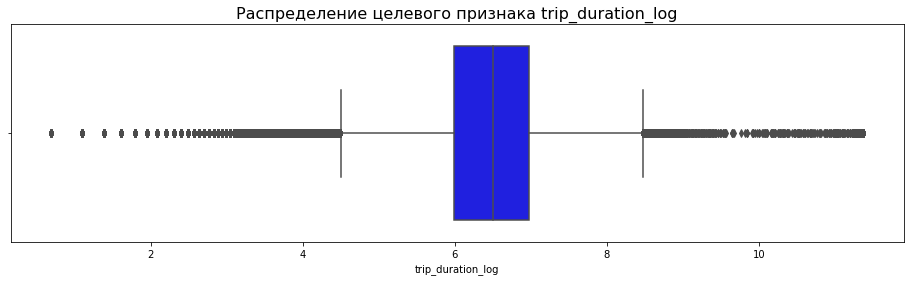

In [83]:
plt.figure(figsize=(16, 4))
box_trip_dur = sns.boxplot(data=taxi_data, x='trip_duration_log', color='blue')
box_trip_dur.axes.set_title('Распределение целевого признака trip_duration_log', fontsize=16)

In [84]:
_, p = stats.normaltest(taxi_data['trip_duration_log'])
alpha = 0.05

if p > alpha:
    print('Распределение нормальное')
else:
    print('Распредление отличное от нормального')
print('Значение p-value:', p)


Распредление отличное от нормального
Значение p-value: 0.0


Text(0.5, 1.0, 'Распределение целевого признака trip_duration_log в зависимости от vendor_id')

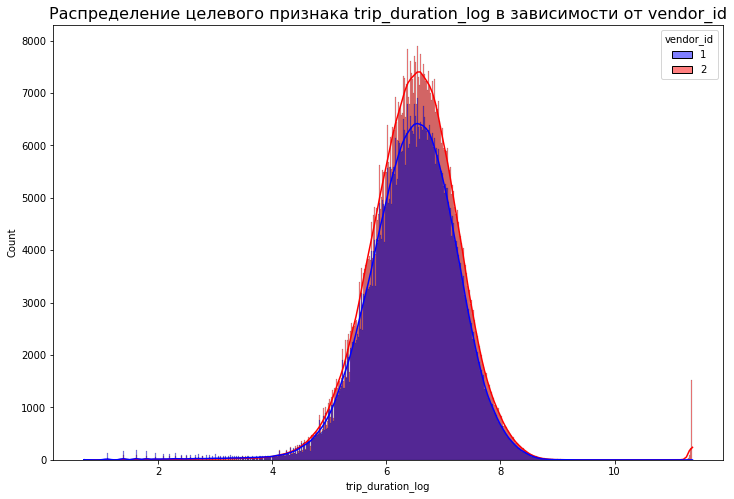

In [85]:
plt.figure(figsize=(12, 8))
hist_trip_dur = sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', kde=True, palette={1: 'blue', 2: 'red'})
hist_trip_dur.axes.set_title('Распределение целевого признака trip_duration_log в зависимости от vendor_id', fontsize=16)

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки. 

Text(0.5, 1.0, 'Распределение целевого признака trip_duration_log в зависимости от store_and_fwd_flag')

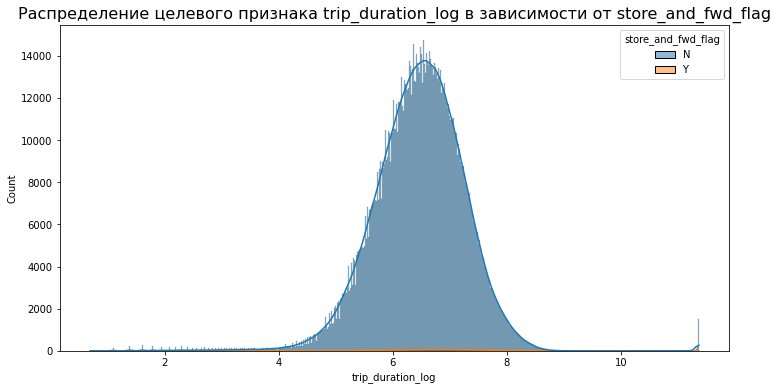

In [86]:
plt.figure(figsize=(12, 6))
hist_trip_dur = sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', kde=True)
hist_trip_dur.axes.set_title('Распределение целевого признака trip_duration_log в зависимости от store_and_fwd_flag', fontsize=16)

Text(0.5, 1.0, 'Распределение целевого признака trip_duration_log от store_and_fwd_flag')

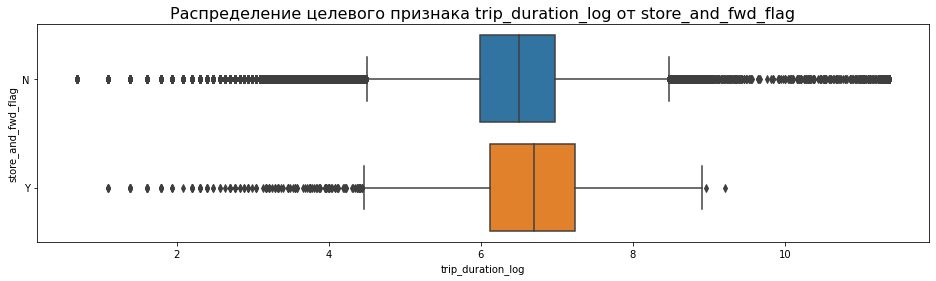

In [87]:
plt.figure(figsize=(16, 4))
box_trip_dur = sns.boxplot(data=taxi_data, x='trip_duration_log', y='store_and_fwd_flag')
box_trip_dur.axes.set_title('Распределение целевого признака trip_duration_log от store_and_fwd_flag', fontsize=16)

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки. 

In [88]:
trip_from_hour = taxi_data.groupby(['pickup_hour'], as_index=False)['id'].count()
med_dur_from_hour = taxi_data.groupby(['pickup_hour'], as_index=False)['trip_duration'].median()

Text(0.5, 1.0, 'Количество поездок в зависимости от часа')

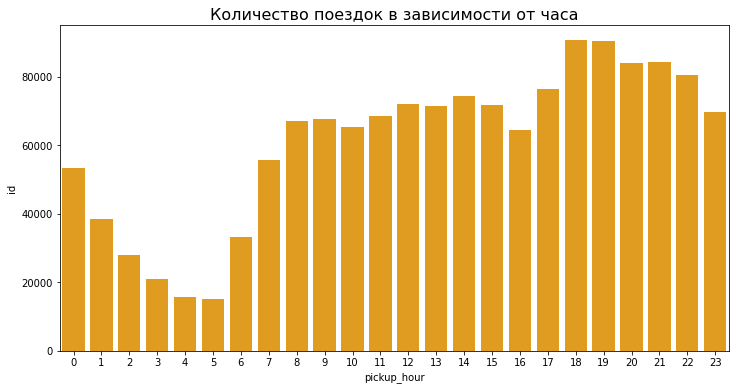

In [89]:
plt.figure(figsize=(12, 6))
trip_from_hour_sns = sns.barplot(data=trip_from_hour, x='pickup_hour', y='id', color='orange')
trip_from_hour_sns.axes.set_title('Количество поездок в зависимости от часа', fontsize=16)

Text(0.5, 1.0, 'Медианная продолжительность поездки в зависимости от часа')

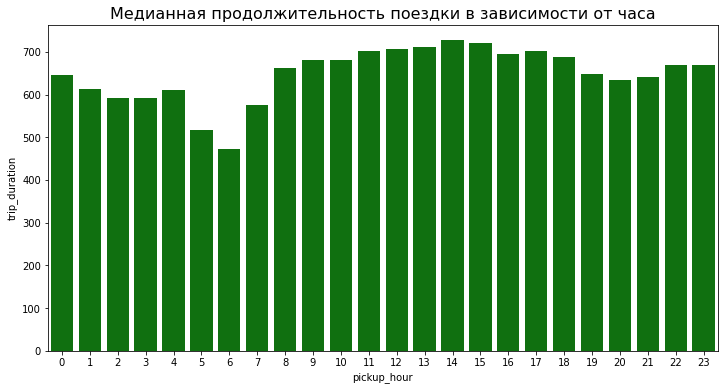

In [90]:
plt.figure(figsize=(12, 6))
med_dur_from_hour_sns = sns.barplot(data=med_dur_from_hour, x='pickup_hour', y='trip_duration', color='green')
med_dur_from_hour_sns.axes.set_title('Медианная продолжительность поездки в зависимости от часа', fontsize=16)

In [91]:
trip_from_day = taxi_data.groupby(['pickup_day_of_week'], as_index=False)['id'].count()
med_dur_from_day = taxi_data.groupby(['pickup_day_of_week'], as_index=False)['trip_duration'].median()

Text(0.5, 1.0, 'Количество поездок в зависимости от дня недели')

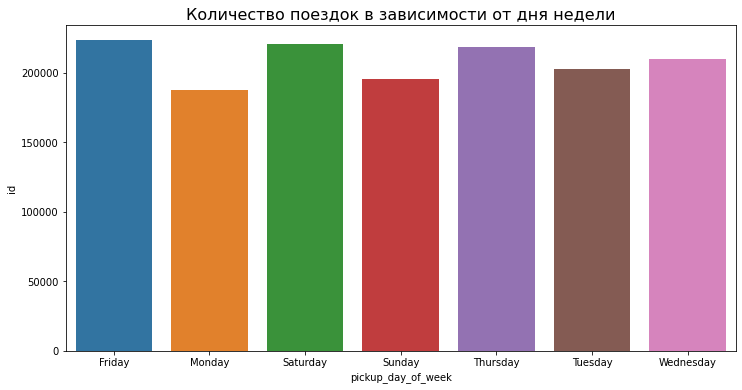

In [92]:
plt.figure(figsize=(12, 6))
trip_from_day_sns = sns.barplot(data=trip_from_day, x='pickup_day_of_week', y='id')
trip_from_day_sns.axes.set_title('Количество поездок в зависимости от дня недели', fontsize=16)

Text(0.5, 1.0, 'Медианная продолжительность поездки в зависимости от дня недели')

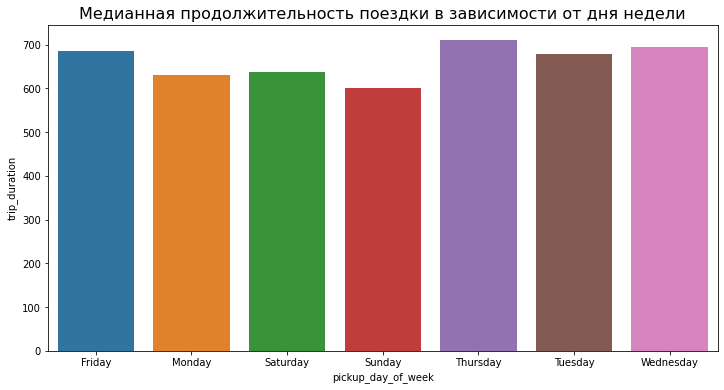

In [93]:
plt.figure(figsize=(12, 6))
med_dur_from_day_sns = sns.barplot(data=med_dur_from_day, x='pickup_day_of_week', y='trip_duration')
med_dur_from_day_sns.axes.set_title('Медианная продолжительность поездки в зависимости от дня недели', fontsize=16)

In [94]:
piv_med_trip = pd.pivot_table(taxi_data, 
                              values='trip_duration', 
                              index='pickup_hour', 
                              columns='pickup_day_of_week', 
                              aggfunc='median'
                              )

Text(0.5, 1.0, 'Медианная длительность поездки в зависимости от дня недели')

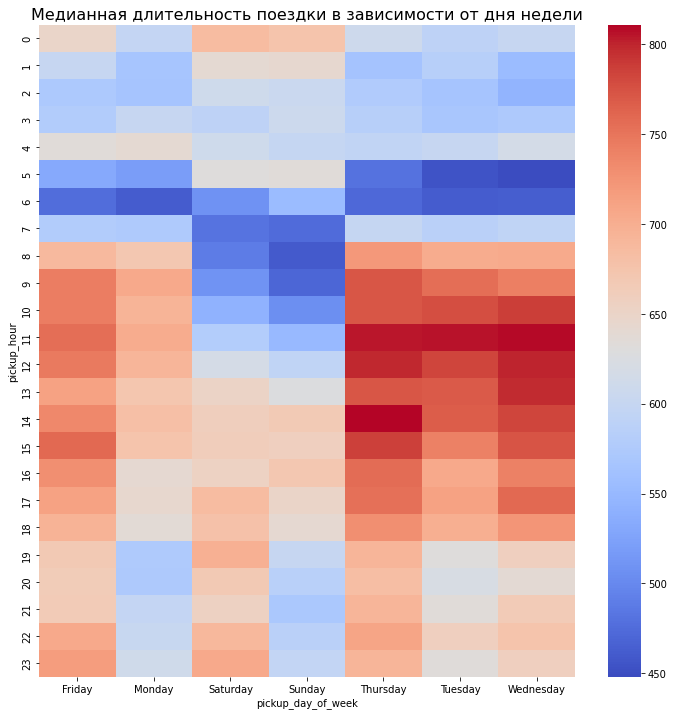

In [95]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=piv_med_trip, cmap='coolwarm')
plt.title('Медианная длительность поездки в зависимости от дня недели', fontsize=16)

Построим две диаграммы рассеяния:
* первая иллюстрирует географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая иллюстрирует географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Диаграмы включают расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 


In [96]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

df_start = taxi_data[
      (taxi_data['pickup_longitude'] >= -74.03) &
      (taxi_data['pickup_longitude'] <= -73.75)&
      (taxi_data['pickup_latitude'] >= 40.63) &
      (taxi_data['pickup_latitude'] <= 40.85)]

df_end = taxi_data[
      (taxi_data['dropoff_longitude'] >= -74.03) &
      (taxi_data['dropoff_longitude'] <= -73.75) &
      (taxi_data['dropoff_latitude'] >= 40.63) &
      (taxi_data['dropoff_latitude'] <= 40.85)]

print(df_start['geo_cluster'].unique())
print(df_end['geo_cluster'].unique())

[9 4 0 5 1 3 7 6]
[9 4 0 5 1 3 7]


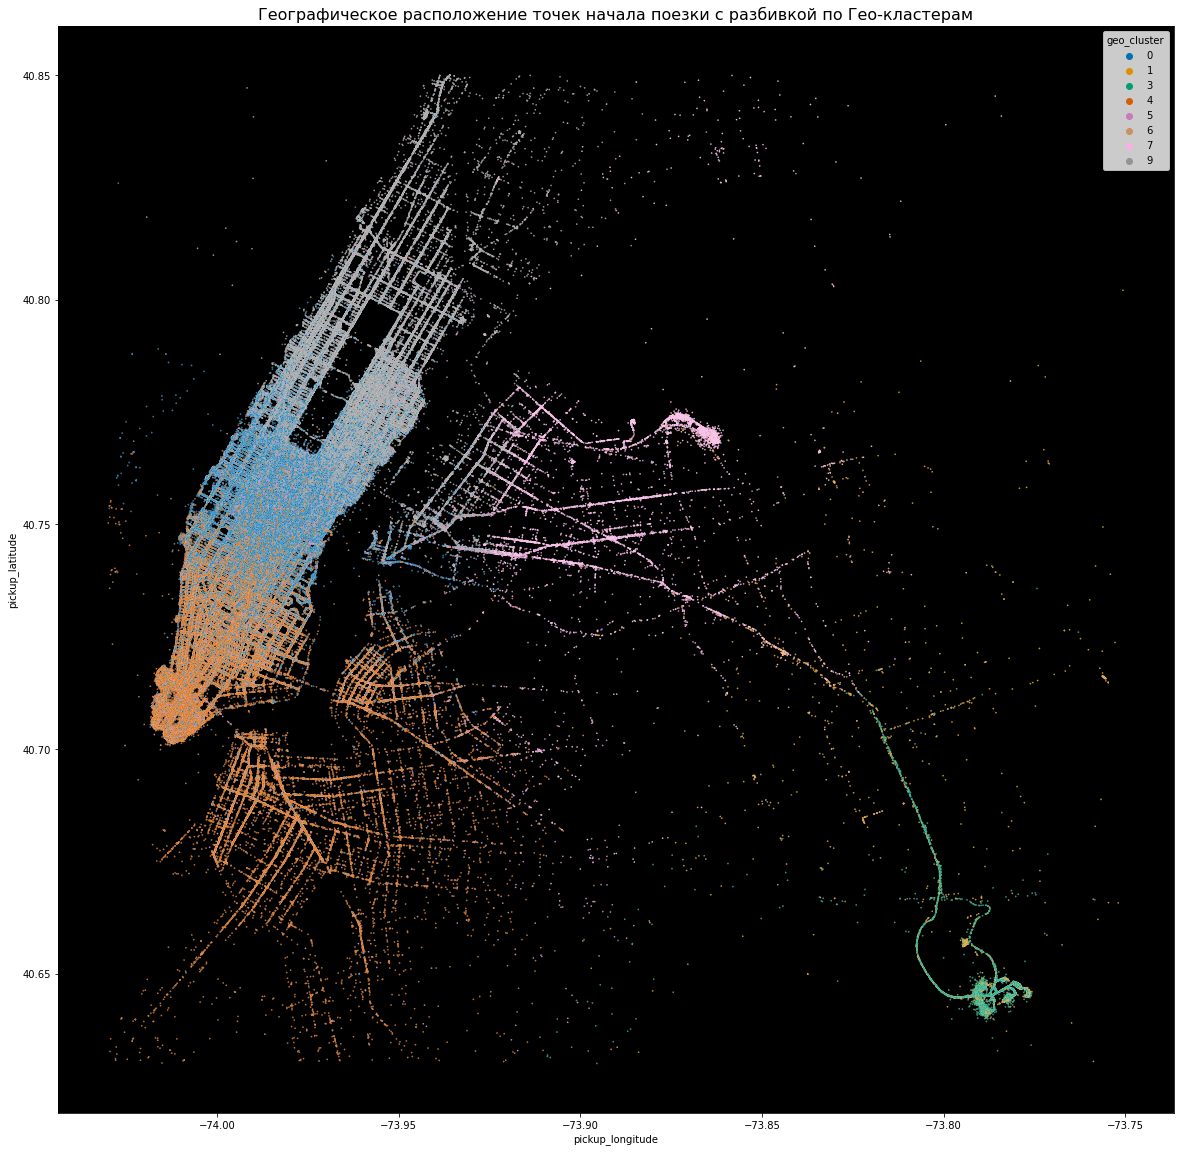

In [97]:
plt.figure(figsize=(20, 20))
geo_start = sns.scatterplot(data=df_start, x='pickup_longitude', y='pickup_latitude', hue=df_start['geo_cluster'], s=2, palette='colorblind')
plt.title('Географическое расположение точек начала поезки с разбивкой по Гео-кластерам', fontsize=16)
geo_start.set_facecolor("black")

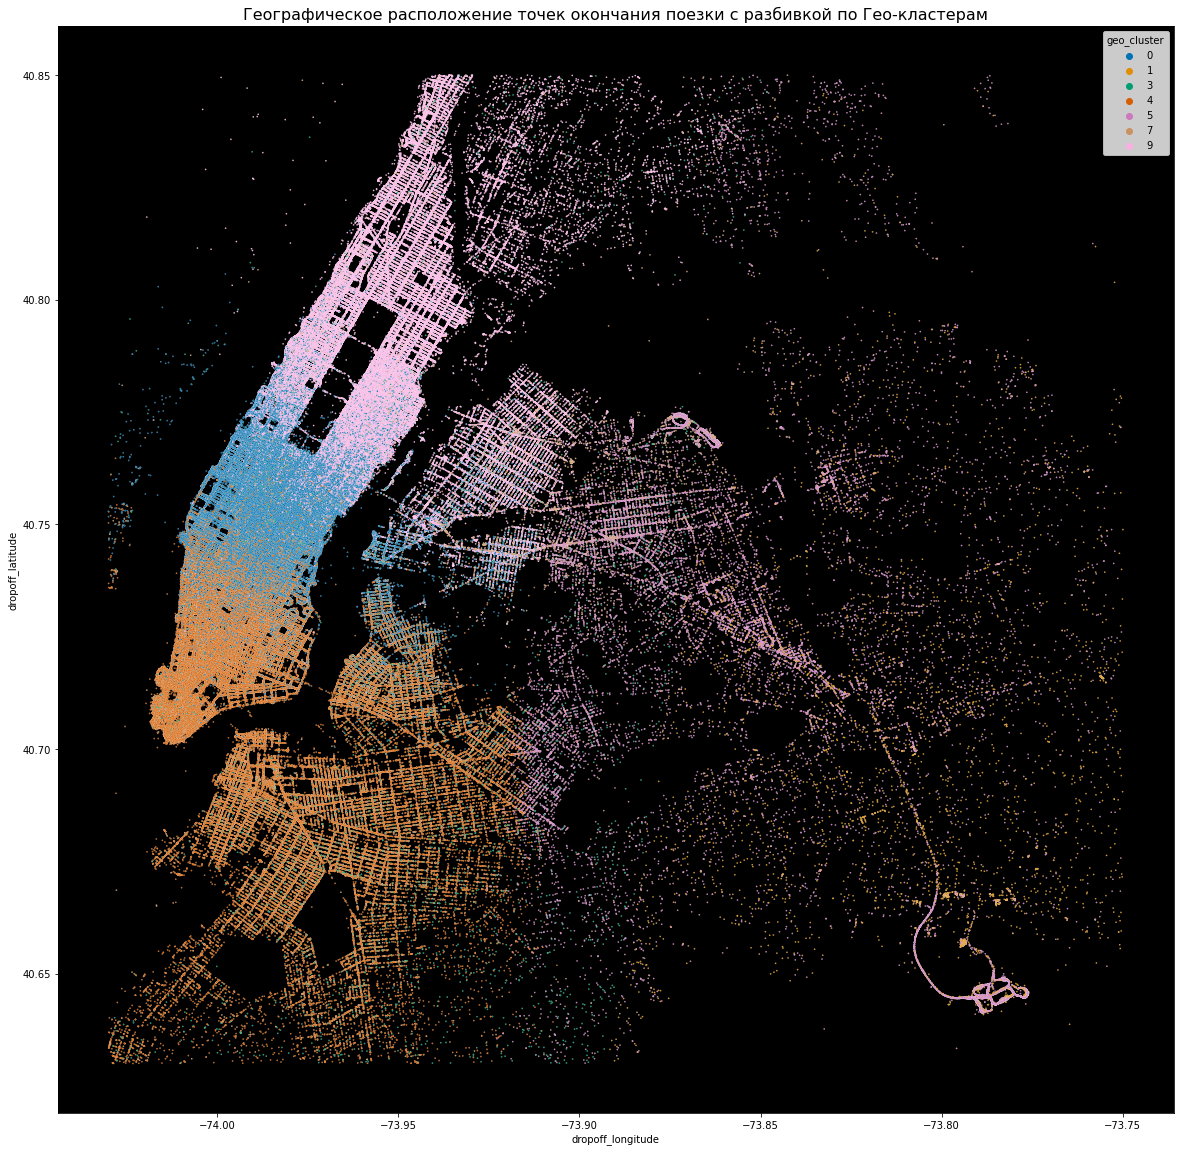

In [98]:
plt.figure(figsize=(20, 20))
geo_end = sns.scatterplot(data=df_end, x='dropoff_longitude', y='dropoff_latitude', hue=df_end['geo_cluster'], s=2, palette='colorblind')
plt.title('Географическое расположение точек окончания поезки с разбивкой по Гео-кластерам', fontsize=16)
geo_end.set_facecolor("black")

## 4. Отбор и преобразование признаков

In [99]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


In [100]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)

In [101]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)

In [102]:
#кодируем признак vendor_id в таблице train_data, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 в противном случае.
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
#кодируем признак store_and_fwd_flag в таблице train_data, чтобы он был равен 0, если флаг выставлен в значение "N", и 1 в противном случае.
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

### 4.1. Кодирование признаков

In [103]:
#таблица data_onehot из закодированных признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

one_hot_encoder = preprocessing.OneHotEncoder(drop='first')
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

Добавим полученную таблицу с закодированными признаками:

In [104]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [105]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

### 4.2. Деление данных

Выбранный тип валидации - hold-out. Разбиваем выборку на обучающую и валидационную в соотношении 67/33:

In [106]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

У нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### 4.3. Отбор признаков
С помощью SelectKBest отбираем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе.

In [107]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)

X_train = selector.transform(X_train)
X_valid = selector.transform(X_valid)
selector_columns = selector.get_feature_names_out()

print(selector_columns)


['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Monday'
 'pickup_day_of_week_Saturday' 'pickup_day_of_week_Sunday'
 'pickup_day_of_week_Thursday' 'pickup_day_of_week_Tuesday'
 'pickup_day_of_week_Wednesday' 'geo_cluster_1' 'geo_cluster_3'
 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


### 4.4. Масштабирование признаков

In [108]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

print(X_valid[:, 0].mean().round(2))

0.54


## 5. Линейная регрессия и деревья решений

### 5.1. Линейная регрессия


In [109]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train_log)

y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
print('Train RMSLE on train fold: {:.3f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False)))
print('Train RMSLE on valid fold: {:.3f}'.format(metrics.mean_squared_error(y_valid_log, y_valid_pred, squared=False)))

Train RMSLE on train fold: 0.536
Train RMSLE on valid fold: 0.538


### 5.2. Полиноминальные признаки
Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures.

In [110]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.fit_transform(X_valid)

lr.fit(X_train_poly, y_train_log)

y_train_pred_poly = lr.predict(X_train_poly)
y_valid_pred_poly = lr.predict(X_valid_poly)
print('Train RMSLE on train fold: {:.3f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred_poly, squared=False)))
print('Train RMSLE on valid fold: {:.2f}'.format(metrics.mean_squared_error(y_valid_log, y_valid_pred_poly, squared=False)))

Train RMSLE on train fold: 0.466
Train RMSLE on valid fold: 0.70


### 5.3. Полиноминальная регрессия с регуляризацией
Строим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией.

In [111]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.fit_transform(X_valid)

ridge = linear_model.Ridge(alpha=1)

ridge.fit(X_train_poly, y_train_log)

y_train_pred_poly_l2 = ridge.predict(X_train_poly)
y_valid_pred_poly_l2 = ridge.predict(X_valid_poly)
print('Train RMSLE on train fold: {:.3f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred_poly_l2, squared=False)))
print('Train RMSLE on valid fold: {:.2f}'.format(metrics.mean_squared_error(y_valid_log, y_valid_pred_poly_l2, squared=False)))

Train RMSLE on train fold: 0.477
Train RMSLE on valid fold: 0.48


### 5.4. Дерево решений
Строим модель дерева решений на обучающей выборке.

In [112]:
tree_reg = tree.DecisionTreeRegressor(random_state=42)

tree_reg.fit(X_train, y_train_log)

y_train_pred_tree = tree_reg.predict(X_train)
y_valid_pred_tree = tree_reg.predict(X_valid)
print('Train RMSLE on train fold: {:.3f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred_tree, squared=False)))
print('Train RMSLE on valid fold: {:.3f}'.format(metrics.mean_squared_error(y_valid_log, y_valid_pred_tree, squared=False)))

Train RMSLE on train fold: 0.003
Train RMSLE on valid fold: 0.566


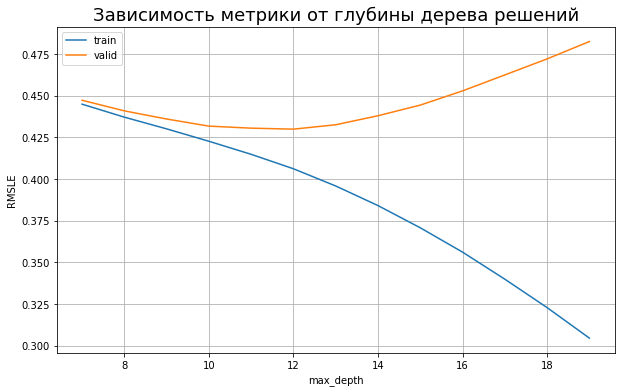

In [113]:
def get_rmsle_metrics(model: any, x_train: np.array, y_train: np.array,
                      x_valid: np.array, y_valid: np.array,
                      return_result: bool = False,
                      print_result: bool = True) -> tuple:
    """
    :param model: обученная модель
    :param x_train: обучающий датасет
    :param y_train: логарифмированная обучающая целевая переменная
    :param x_valid: проверочный датасет
    :param y_valid: логарифмированная проверочная целевая переменная
    :param return_result: флаг возвращать ли значения метрик
    :param print_result: флаг печатать ли метрики
    :return: None или кортеж из обучающей и тестовой метрик
    """
    rmsle_train = metrics.mean_squared_error(y_train,
                                            model.predict(x_train),
                                            squared=False)
    rmsle_valid = metrics.mean_squared_error(y_valid,
                                             model.predict(x_valid),
                                             squared=False)
    if print_result:
        print(f'RMSLE на обучающей выборке: {rmsle_train:.2f}.',
              f'RMSLE на тестовой выборке: {rmsle_valid:.2f}.',
              sep='\n')
    if return_result:
        return rmsle_train, rmsle_valid


RMSLE_train_list, RMSLE_valid_list = [], []
for depth in range(7, 20):
    estimator = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
    estimator.fit(X_train, y_train_log)
    RMSLE_train, RMSLE_valid = get_rmsle_metrics(model=estimator,
                                                 x_train=X_train,
                                                 y_train=y_train_log,
                                                 x_valid=X_valid,
                                                 y_valid=y_valid_log,
                                                 print_result=False,
                                                 return_result=True)
    RMSLE_train_list.append(RMSLE_train)
    RMSLE_valid_list.append(RMSLE_valid)

metrics_data = pd.DataFrame(np.array([RMSLE_train_list, RMSLE_valid_list]).T,
                            columns=['train', 'valid'],
                            index=range(7, 20))
fig_55, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=metrics_data, dashes=False, ax=ax)\
    .set_title('Зависимость метрики от глубины дерева решений', fontsize=18)
ax.set_ylabel('RMSLE')
ax.set_xlabel('max_depth')
plt.grid()
plt.show(fig_55)

In [114]:
metrics_data

,train,valid
7,0.444822,0.447174
8,0.437048,0.440817
9,0.430022,0.435937
10,0.422599,0.431669
11,0.414765,0.430444
12,0.406102,0.429857
13,0.395787,0.432485
14,0.384035,0.437893
15,0.370728,0.444272
16,0.356135,0.452781


## 6. Ансамблевые методы и построение прогноза

### 6.1. Случайный лес

Строим модель случайного леса на обучающей выборке В качестве гиперпараметров принимаем:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

In [115]:
rf = ensemble.RandomForestRegressor(n_estimators=200,
                                    max_depth=12,
                                    criterion='squared_error',
                                    min_samples_split=20,
                                    random_state=42
                                    )

rf.fit(X_train, y_train_log)

y_train_pred_rf = rf.predict(X_train)
y_valid_pred_rf = rf.predict(X_valid)

print('Train RMSLE on train fold: {:.3f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred_rf, squared=False)))
print('Train RMSLE on valid fold: {:.3f}'.format(metrics.mean_squared_error(y_valid_log, y_valid_pred_rf, squared=False)))

Train RMSLE on train fold: 0.399
Train RMSLE on valid fold: 0.414


### 6.2. Градиентный бустинг
Строим модель градиентного бустинга над деревьями решений. В качестве гиперпараметров принимаем:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

In [116]:
gbr = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                         n_estimators=100,
                                         max_depth=6, 
                                         min_samples_split=30,
                                         random_state=42
                                         )

gbr.fit(X_train, y_train_log)

y_train_pred_gbr = gbr.predict(X_train)
y_valid_pred_gbr = gbr.predict(X_valid)

print('Train RMSLE on train fold: {:.3f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred_gbr, squared=False)))
print('Train RMSLE on valid fold: {:.3f}'.format(metrics.mean_squared_error(y_valid_log, y_valid_pred_gbr, squared=False)))

Train RMSLE on train fold: 0.370
Train RMSLE on valid fold: 0.393


<AxesSubplot:>

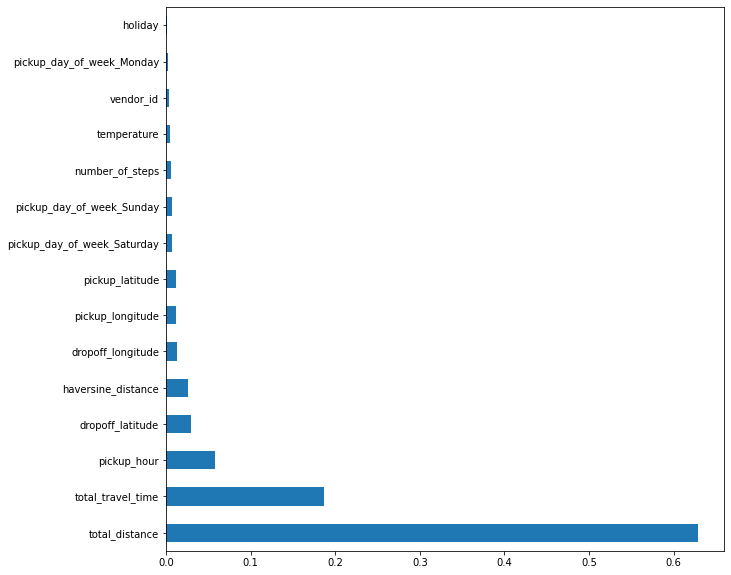

In [117]:
X_train_df = pd.DataFrame(data=X_train, columns=selector_columns)
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gbr.feature_importances_, index=X_train_df.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [118]:
foo = np.vectorize(lambda v: np.exp(v) - 1)
y_valid, y_pred = foo(y_valid_log), foo(y_valid_pred_gbr)

print('Train MeAE on valid fold: {:.3f}'.format(metrics.median_absolute_error(y_valid, y_pred)/60))

Train MeAE on valid fold: 1.831


Прочитаем тестовые данные и выделим столбец с идентификаторами поездок из тестового набора данных:

In [119]:
test_data = pd.read_csv('data/test_data.csv')
osrm_data_test = pd.read_csv('data/osrm_data_test.csv')
test_id = test_data['id']

In [120]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [121]:
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selector_columns]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


/home/belov_engineer/.local/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [123]:
y_test_predict = np.exp(gbr.predict(X_test_scaled)) - 1

In [124]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

## 7. XGBoost


In [125]:
import xgboost as xgb

In [126]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=selector_columns)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=selector_columns)
dtest = xgb.DMatrix(X_test_scaled, feature_names=selector_columns)

In [127]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
[10]	train-rmse:1.93569	valid-rmse:1.93563
[20]	train-rmse:0.78551	valid-rmse:0.78635
[30]	train-rmse:0.47924	valid-rmse:0.48127
[40]	train-rmse:0.42057	valid-rmse:0.42325
[50]	train-rmse:0.40874	valid-rmse:0.41188
[60]	train-rmse:0.40423	valid-rmse:0.40773
[70]	train-rmse:0.40110	valid-rmse:0.40502
[80]	train-rmse:0.39888	valid-rmse:0.40310
[90]	train-rmse:0.39739	valid-rmse:0.40183
[100]	train-rmse:0.39571	valid-rmse:0.40040
[110]	train-rmse:0.39416	valid-rmse:0.39911
[120]	train-rmse:0.39324	valid-rmse:0.39856
[130]	train-rmse:0.39188	valid-rmse:0.39752
[140]	train-rmse:0.39080	valid-rmse:0.39677
[150]	train-rmse:0.38992	valid-rmse:0.39616
[160]	train-rmse:0.38925	valid-rmse:0.39570
[170]	train-rmse:0.38854	valid-rmse:0.39529
[180]	train-rmse:0.38793	valid-rmse:0.39500
[190]	train-rmse:0.38720	valid-rmse:0.39469
[200]	train-rmse:0.38608	valid-rmse:0.39387
[210]	train-rmse:0.38533	valid-rmse:0.39352
[220]	train-rmse:0.38464	valid-rmse:0.39326

In [128]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39107


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

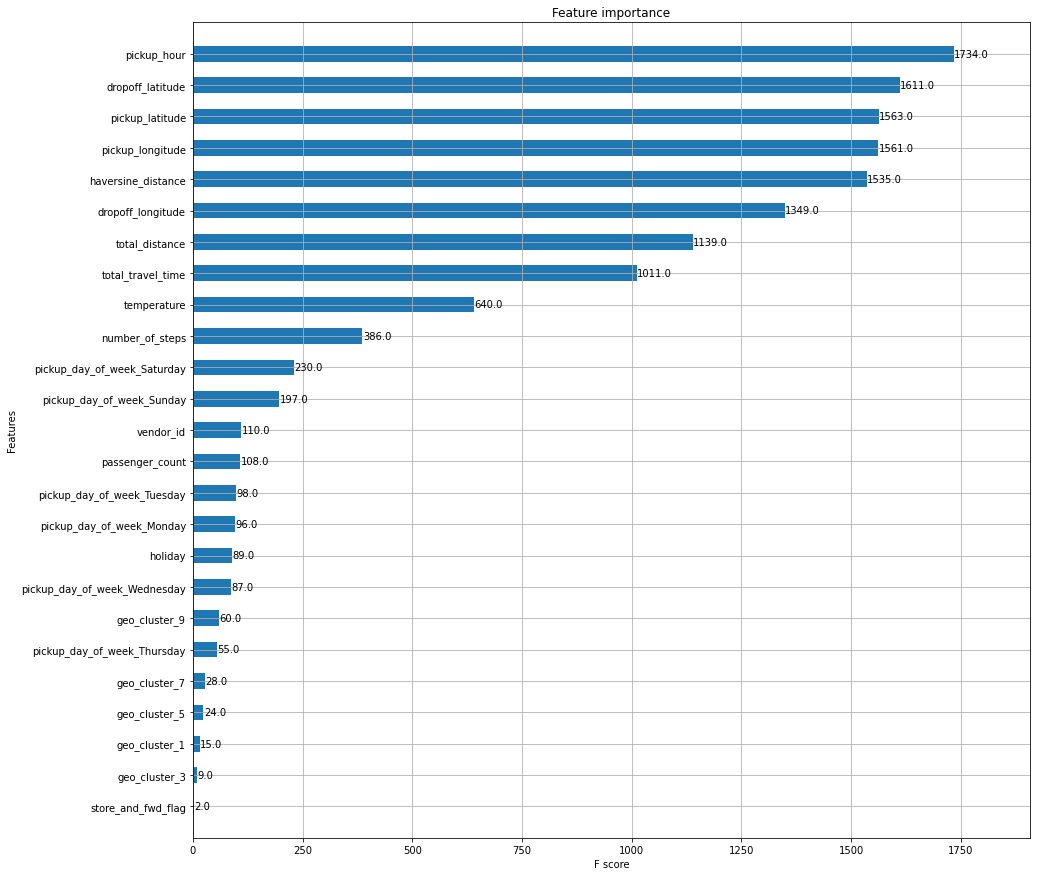

In [129]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)